In [1]:
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import torch
import numpy as np
import gdown

from scarches.dataset.trvae.data_handling import remove_sparsity

from polyphony import Polyphony
from polyphony.utils.visualize import display_umap

Global seed set to 0


In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [4]:
cache_dir = 'scvi_example/'
os.makedirs(cache_dir, exist_ok=True)
os.chdir(cache_dir)

data_output = 'pancreas.h5ad'

# Data Preparation

In this example, we use the `Pancreas` dataset from the [scArches example](https://scarches.readthedocs.io/en/latest/scvi_surgery_pipeline.html). Two batches of the data (`Pancreas CelSeq2` and `Pancreas SS2`) are used as for query. And the rest makes up the reference dataset.

In [5]:
condition_key = 'study'
cell_type_key = 'cell_type'
target_conditions = ['Pancreas CelSeq2', 'Pancreas SS2']

In [6]:
if not os.path.exists(data_output):
    url = 'https://drive.google.com/uc?id=1ehxgfHTsMZXy6YzlFKGJOsBKQ5rrvMnd'
    output = 'pancreas.h5ad'
    gdown.download(url, output, quiet=False)
adata_all = sc.read(data_output)

In [7]:
adata = adata_all.raw.to_adata()
adata = remove_sparsity(adata)
source_adata = adata[~adata.obs[condition_key].isin(target_conditions)].copy()
target_adata = adata[adata.obs[condition_key].isin(target_conditions)].copy()

source_adata.obs['source'] = 'reference'
target_adata.obs['source'] = 'query'

# Model Building

In [8]:
pp = Polyphony(source_adata, target_adata)

### Step-0: setup the data

In [9]:
pp.setup_data()

INFO     Using batches from adata.obs["batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 10294 cells, 1000 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          
INFO     Using batches from adata.obs["batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 5

### Step-1: build reference model and the initial query model

In [10]:
pp.init_reference_step()

INFO     Using data from adata.X                                                             
INFO     Registered keys:['X', 'batch_indices', 'labels', 'cell_update', 'desired_rep']      
INFO     Successfully registered anndata object containing 10294 cells, 1000 vars, 3 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Using data from adata.X                                                             
INFO     Registered keys:['X', 'batch_indices', 'labels', 'cell_update', 'desired_rep']      
INFO     Successfully registered anndata object containing 5387 cells, 1000 vars, 5 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


2022-02-17 16:43:28.625845: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Pickle of ParametricUMAP model loaded from /Users/chengfurui/Projects/polyphony/data/umap/model.pkl
Keras encoder model loaded from /Users/chengfurui/Projects/polyphony/data/umap/encoder
Keras full model loaded from /Users/chengfurui/Projects/polyphony/data/umap/parametric_model


2022-02-17 16:43:29.463202: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
... storing 'study' as categorical
... storing 'source' as categorical


<Figure size 320x320 with 0 Axes>

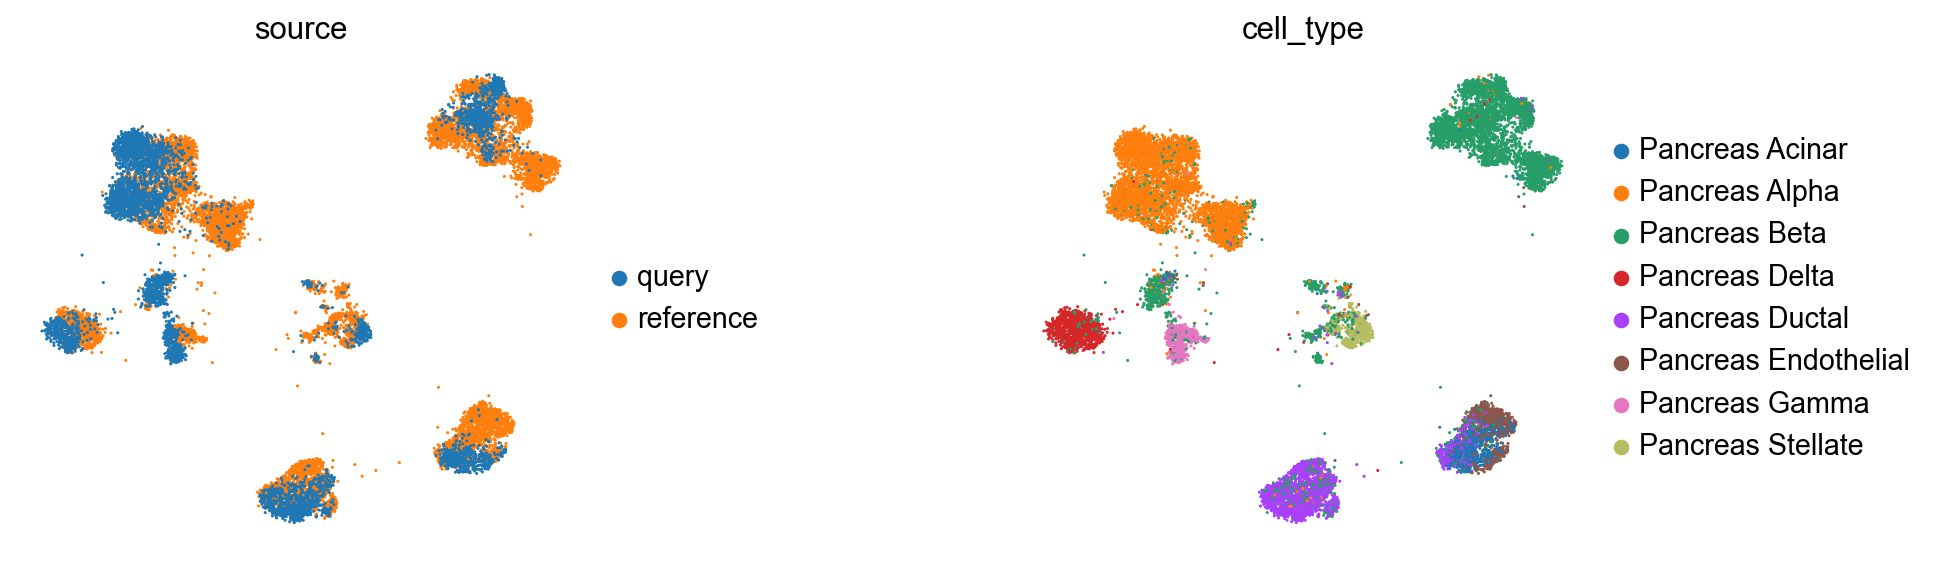

In [11]:
display_umap(pp.full_adata, pp.embedder, color=["source", "cell_type"])

### Step-2: refine the query model 

In [12]:
pp.anchor_update_step()

2022-02-17 16:43:34,355 - harmonypy - INFO - Iteration 1 of 10
2022-02-17 16:43:37,597 - harmonypy - INFO - Iteration 2 of 10
2022-02-17 16:43:41,477 - harmonypy - INFO - Iteration 3 of 10
2022-02-17 16:43:44,866 - harmonypy - INFO - Iteration 4 of 10
2022-02-17 16:43:47,982 - harmonypy - INFO - Iteration 5 of 10
2022-02-17 16:43:51,022 - harmonypy - INFO - Iteration 6 of 10
2022-02-17 16:43:53,830 - harmonypy - INFO - Iteration 7 of 10
2022-02-17 16:43:56,237 - harmonypy - INFO - Iteration 8 of 10
2022-02-17 16:43:58,175 - harmonypy - INFO - Iteration 9 of 10
2022-02-17 16:44:00,085 - harmonypy - INFO - Iteration 10 of 10
2022-02-17 16:44:01,619 - harmonypy - INFO - Stopped before convergence
/Users/chengfurui/Projects/polyphony/polyphony/anchor_recom/_harmony_recom.py:50: RuntimeWarning: invalid value encountered in true_divide
  query_centers = np.dot(query_assign, self.query_latent) / query_count[:, None]
/Users/chengfurui/Projects/polyphony/polyphony/anchor_recom/_harmony_recom.py

INFO     Using data from adata.X                                                             
INFO     Registered keys:['X', 'batch_indices', 'labels', 'cell_update', 'desired_rep']      
INFO     Successfully registered anndata object containing 5387 cells, 1000 vars, 5 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Epoch 400/400: 100%|███████████████████████| 400/400 [05:18<00:00,  1.26it/s, loss=1.18e+03, v_num=1]


... storing 'study' as categorical
... storing 'source' as categorical


<Figure size 320x320 with 0 Axes>

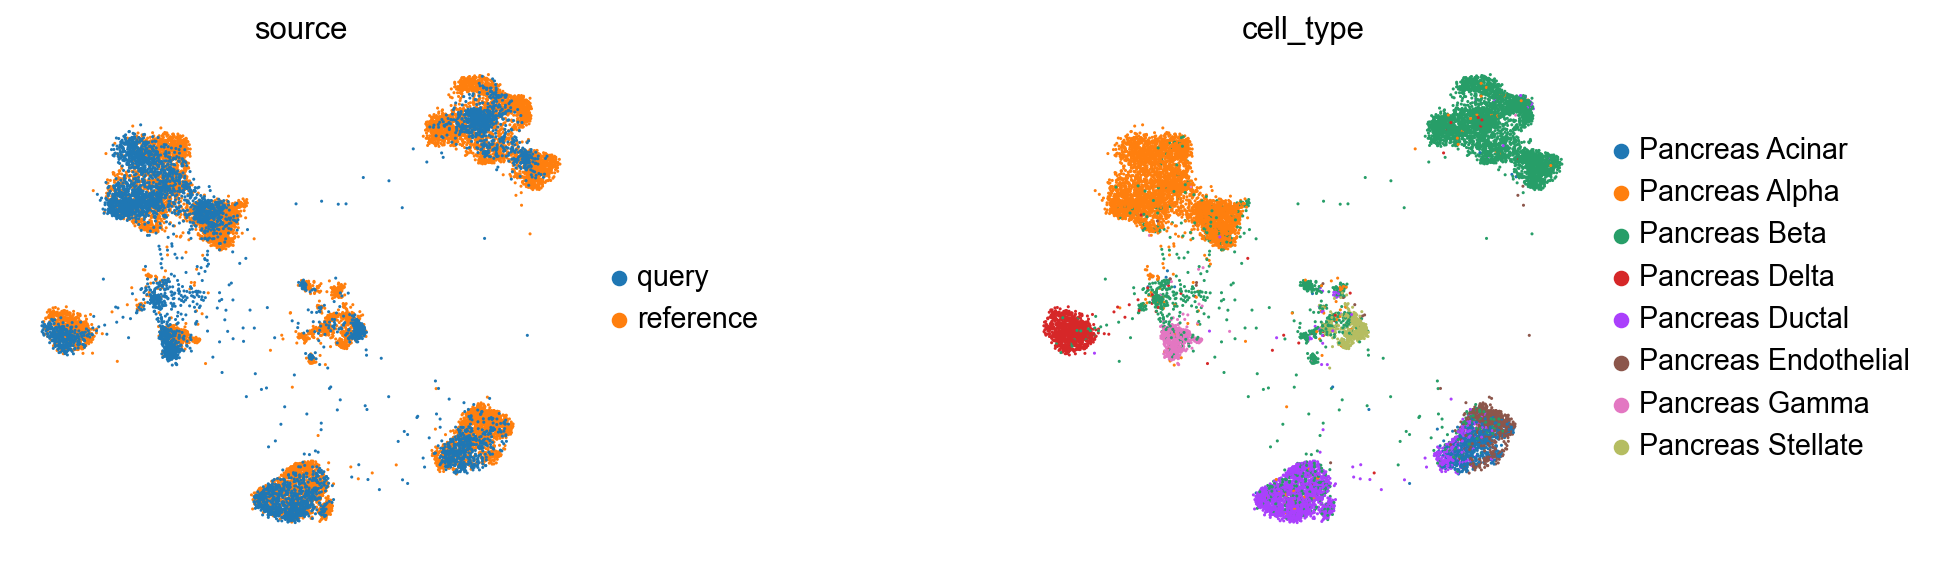

In [13]:
display_umap(pp.full_adata, pp.embedder, color=["source", "cell_type"])